### Проект 1. Воронка

Для того чтобы отслеживать, как выглядит путь клиента от знакомства с продуктом до его получения, и какие в нем есть проблемные места, аналитики часто строят воронки. Этот инструмент позволяет понять, сколько клиентов "теряется" на каждом из этапов процесса и сколько в итоге совершает целевое действие.

Перед вами схема данных проекта Тинькофф квест. Постройте воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

Какие выводы можно сделать исходя из построенной воронки, какие точки роста продукта вы видите?
Задание нужно выполнить в JupyterNotebook \ Google Colab.

Этапы:
- Подключиться к базе данных с помощью Python в JupyterNotebook \ Google Colab
- Собрать датасет с необходимыми полями
- Посчитать конверсии и сделать визуализацию на Python
- Прикрепить файл с выполненным заданием

In [3]:
import datetime as dt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2

In [3]:
# выгрузка данных
connection = psycopg2.connect(database="postgres", 
                        user="student", 
                        password="JvLda93aA", 
                        host="158.160.52.106", 
                        port="5432")
cursor = connection.cursor()

data_by_month = pd.DataFrame(pd.read_sql(
    "SELECT DATE_TRUNC('year', c.Visit_dttm) AS year, DATE_TRUNC('month', c.Visit_dttm) AS month, "
    "COALESCE(COUNT(DISTINCT c.Client_rk), 0) AS visitors, COALESCE(COUNT(DISTINCT a.Account_rk), 0) AS accounts, "
    "COALESCE(COUNT(DISTINCT app.Game_rk), 0) AS apps, COALESCE(COUNT(DISTINCT g.Game_rk), 0) AS gamers "
    "FROM msu_analytics.client c "
    "LEFT JOIN msu_analytics.account a ON DATE(c.Visit_dttm) = Date(a.Registration_dttm) "
    "LEFT JOIN msu_analytics.Application app ON DATE(c.Visit_dttm) = DATE(app.Application_dttm) "
    "LEFT JOIN (SELECT * FROM msu_analytics.game g WHERE g.Game_flg = 1 ORDER BY 1) g "
    "ON DATE(c.Visit_dttm) = DATE(g.Game_dttm) "
    "GROUP BY 1, 2 "
    "ORDER BY 1, 2",
    connnection
))

data_by_week = pd.DataFrame(pd.read_sql(
    "SELECT DATE_TRUNC('year', c.Visit_dttm) AS year, DATE_TRUNC('week', c.Visit_dttm) AS week, "
    "COALESCE(COUNT(DISTINCT c.Client_rk), 0) AS visitors, COALESCE(COUNT(DISTINCT a.Account_rk), 0) AS accounts, "
    "COALESCE(COUNT(DISTINCT app.Game_rk), 0) AS apps, COALESCE(COUNT(DISTINCT g.Game_rk), 0) AS gamers "
    "FROM msu_analytics.client c "
    "LEFT JOIN msu_analytics.account a ON DATE(c.Visit_dttm) = Date(a.Registration_dttm) "
    "LEFT JOIN msu_analytics.Application app ON DATE(c.Visit_dttm) = DATE(app.Application_dttm) "
    "LEFT JOIN (SELECT * FROM msu_analytics.game g WHERE g.Game_flg = 1 ORDER BY 1) g "
    "ON DATE(c.Visit_dttm) = DATE(g.Game_dttm) "
    "GROUP BY 1, 2 "
    "ORDER BY 1, 2",
    connection
))

data_by_month.head()
data_by_week.tail()

        year      month  visitors  accounts  apps  gamers
0 2022-01-01 2022-09-01       778       186    58       2
1 2022-01-01 2022-10-01       843       219    98      21
2 2022-01-01 2022-11-01       786       195    96      43
3 2022-01-01 2022-12-01       805       200    88      47
4 2023-01-01 2023-01-01       852       215   118      63
         year       week  visitors  accounts  apps  gamers
19 2023-01-01 2023-01-02       201        55    23      16
20 2023-01-01 2023-01-09       205        54    23       8
21 2023-01-01 2023-01-16       181        42    40      15
22 2023-01-01 2023-01-23       182        40    32      17
23 2023-01-01 2023-01-30        81        26    11       9


Поля в таблицах:
- visitors = число посетителей сайта
- accounts = число зарегистрировавшихся на сайте
- applications = число заявок на игру
- gamers = итоговое число людей, пришедших на игру

In [ ]:
#группируем поля датафрейма по месяцам и считаем конверсии для ступеней воронки
by_month = data_by_month.copy()
by_month['vis-acc'] = by_month['accounts']/by_month['visitors']
by_month['acc-app'] = by_month['apps']/by_month['accounts']
by_month['app-gam'] = by_month['gamers']/by_month['apps']
by_month = by_month.fillna(0) # замена Nan от деления на 0 на нули


#группируем поля по неделям и считаем конверсии для ступеней воронки
by_week = data_by_week.copy()
by_week['vis-acc'] = by_week['accounts']/by_week['visitors']
by_week['acc-app'] = by_week['apps']/by_week['accounts']
by_week['app-gam'] = by_week['gamers']/by_week['apps']
by_week = by_week.fillna(0)

In [5]:
by_week.describe()
by_month.describe()

         visitors   accounts       apps     gamers    vis-acc    acc-app  \
count   24.000000  24.000000  24.000000  24.000000  24.000000  24.000000   
mean   170.666667  42.666667  21.083333   7.458333   0.248811   0.496624   
std     40.369669  11.540728   9.016491   5.274872   0.030550   0.197513   
min     34.000000   7.000000   0.000000   0.000000   0.198198   0.000000   
25%    170.250000  39.500000  18.000000   2.500000   0.233138   0.397321   
50%    181.000000  44.500000  22.000000   7.500000   0.250026   0.490090   
75%    192.750000  49.000000  25.500000  10.250000   0.263888   0.586957   
max    205.000000  59.000000  40.000000  17.000000   0.320988   0.952381   

         app-gam  
count  24.000000  
mean    0.339848  
std     0.244386  
min     0.000000  
25%     0.141414  
50%     0.326667  
75%     0.527549  
max     0.818182  
         visitors    accounts        apps     gamers   vis-acc   acc-app  \
count    6.000000    6.000000    6.000000   6.000000  6.000000  6.00

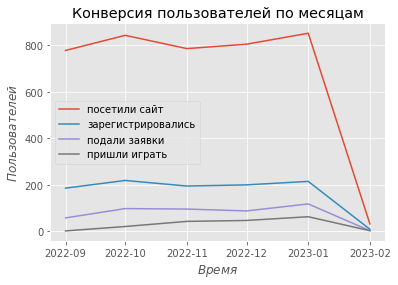

In [21]:
plt.plot(by_month['month'],by_month['visitors'], label="посетили сайт")
plt.plot(by_month['month'],by_month['accounts'], label="зарегистрировались")
plt.plot(by_month['month'],by_month['apps'], label="подали заявки")
plt.plot(by_month['month'],by_month['gamers'], label="пришли играть")
plt.xlabel(r'$Время$')
plt.ylabel(r'$Пользователей$')
plt.title("Конверсия пользователей по месяцам")
plt.legend(loc='best', fontsize=10)

plt.grid(True)
plt.style.use('ggplot')
plt.show()

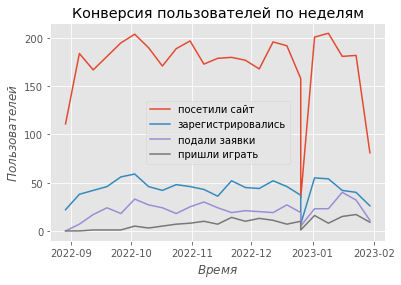

In [23]:
plt.plot(by_week['week'],by_week['visitors'], label="посетили сайт")
plt.plot(by_week['week'],by_week['accounts'], label="зарегистрировались")
plt.plot(by_week['week'],by_week['apps'], label="подали заявки")
plt.plot(by_week['week'],by_week['gamers'], label="пришли играть")
plt.xlabel(r'$Время$')
plt.ylabel(r'$Пользователей$')
plt.title("Конверсия пользователей по неделям")
plt.legend(loc='best', fontsize=10)

plt.grid(True)
plt.style.use('ggplot')
plt.show()

In [96]:
#Строим график конверсии по месяцам
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=by_month['month'], y=by_month['visitors'],mode='lines+markers', name='посетили сайт'),secondary_y=False)
fig.add_trace(go.Scatter(x=by_month['month'], y=by_month['accounts'],mode='lines+markers', name='зарегистрировались'),secondary_y=False)
fig.add_trace(go.Scatter(x=by_month['month'], y=by_month['apps'],mode='lines+markers', name='подали заявки'),secondary_y=False)
fig.add_trace(go.Scatter(x=by_month['month'], y=by_month['gamers'],mode='lines+markers', name='пришли на игру'),secondary_y=False)
fig.add_trace(go.Scatter(x=by_month['month'], y=by_week['vis-acc'],mode='lines+markers', name='conv_1'),secondary_y=True)
fig.add_trace(go.Scatter(x=by_month['month'], y=by_week['acc-app'],mode='lines+markers', name='conv_2'),secondary_y=True)
fig.add_trace(go.Scatter(x=by_month['month'], y=by_week['app-gam'],mode='lines+markers', name='conv_3'),secondary_y=True)

fig.update_layout(legend_orientation = "h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Конверсия пользователей по неделям",
                  xaxis_title="Время",
                  yaxis_title="Число пользователей",
                  margin=dict(l=5, r=5, t=35, b=5))
fig.show()

In [95]:
#Строим график конверсии по неделям
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=by_week['week'], y=by_week['visitors'],mode='lines+markers', name='посетили сайт'),secondary_y=False)
fig.add_trace(go.Scatter(x=by_week['week'], y=by_week['accounts'], mode='lines+markers', name='зарегистрировались'),secondary_y=False)
fig.add_trace(go.Scatter(x=by_week['week'], y=by_week['apps'],mode='lines+markers', name='подали заявки'),secondary_y=False)
fig.add_trace(go.Scatter(x=by_week['week'], y=by_week['gamers'],mode='lines+markers', name='пришли на игру'),secondary_y=False)
fig.add_trace(go.Scatter(x=by_week['week'], y=by_week['vis-acc'],mode='lines+markers', name='conv_1'),secondary_y=True)
fig.add_trace(go.Scatter(x=by_week['week'], y=by_week['acc-app'],mode='lines+markers', name='conv_2'),secondary_y=True)
fig.add_trace(go.Scatter(x=by_week['week'], y=by_week['app-gam'],mode='lines+markers', name='conv_3'),secondary_y=True)

fig.update_layout(legend_orientation = "h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Конверсия пользователей по неделям",
                  xaxis_title="Время",
                  yaxis_title="Число пользователей",
                  margin=dict(l=5, r=5, t=35, b=5))
fig.show()

### Выводы:
1. Большинство (около 75%) посетивших сайт пользователей не зарегистрировались на нем, что может быть вызвано нежеланием предоставлять какую-то информацию компании, сложностями заполнения формы регистрации и пр. Возможно, стоит вообще убрать этот шаг или совместить его со следующим для упрощения пользовательского пути. 

2. Немногие зарегистрировавшиеся пользователи подали заявку на игру (примерно 70% от зарегистрированных не доходят до заявки). Для увеличения количества отправленных заявок следует сделать форму более простой и интуитивно понятной для пользователей + регулярно проверять ее (но здесь все зависит от сайта, возможно, некоторые пользователи просто заинтересовались информацией на сайте, но не были заинтересованы в игре).

3. Конверсия сильно падает на этапе приезда на игру. Возможно, стоит выбрать более удобные локации, до которых легко добраться с помощью общественного транспорта или пересмотреть расписание игр.